In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import glob, os
import xml.etree.ElementTree as ET
# %matplotlib widget
pd.options.mode.chained_assignment = None  # default='warn'

def butterworth_filter(data, cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def extract_from_txt(file_path, labels, delimiter='\n'):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    data_dict = {label: [] for label in labels}
    last_delimiter_index = 0
    messages = []
    for i in range(len(lines)):
        if(lines[i].startswith(delimiter)):
            messages.append(lines[last_delimiter_index:i])
            last_delimiter_index = i
    for message in messages:
        message_dict = {label: [] for label in labels}
        for label in labels:
            for line in message:
                    if(line.startswith(label)):
                        message_dict[label].append(float(line.split(':')[1]))
        full = True
        for key in message_dict:
            if(len(message_dict[key]) == 0):
                full=False
                break
        if(full):
            for label in labels:
                data_dict[label].append(message_dict[label][0])

    # for series in data_dict:
    #     print(series, len(data_dict[series]))

    df_raw = pd.DataFrame(data_dict)
    return df_raw

def remove_even_lines(input_file_path, output_file_path):
    with open(input_file_path, 'r') as file:
        lines = file.readlines()
    
    with open(output_file_path, 'w') as file:
        for i, line in enumerate(lines):
            if i % 2 == 0:
                file.write(line)

def extract_fps(xml_string):
    root = ET.fromstring(xml_string)
    video_frame = root.find('.//*[@captureFps][@formatFps]')
    if video_frame is not None:
        capture_fps = str(video_frame.get('captureFps'))
        format_fps = str(video_frame.get('formatFps'))
        return float(capture_fps[:-1]), float(format_fps[:-1])
    else:
        return np.nan, np.nan

In [51]:
plt.ioff() #don't show plots, just save to file

root_dir = './trials_used'
trials = sorted(glob.glob('trial*', root_dir=root_dir))
print(trials)
all_data = {}

energy_time_data = {
    'Rigid':[],
    'SEA':[],
    'PEA':[],
}

good_trials = []
for trial in trials:
    try:
        encoder_file = max(glob.glob(f"{root_dir}/{trial}/data/*encoder.txt"), key=os.path.getctime)
        force_file = max(glob.glob(f"{root_dir}/{trial}/data/*force.txt"), key=os.path.getctime)
        track_file = max(glob.glob(f"{root_dir}/{trial}/data/*_track.csv"), key=os.path.getctime)
        xml_file = max(glob.glob(f"{root_dir}/{trial}/data/*.XML"), key=os.path.getctime)
        print(f"good {trial} ~~~~~~~~~~~~~~~~~~~~~~~")
    except:
        print(f"failed {trial} ~~~~~~~~~~~~~~~~~~~~~~~")
        continue
    good_trials.append(trial)


    df_log = extract_from_txt(
        encoder_file, 
        [
            't',
            'pA',
            'pB',
            'mA',
            'mB',
            'eA', 
            'eB', 
            'I',
            'd0',
            'd1',
            'd2',
            'd3',
            'd4',
        ],
        '#'
    )

    force_data_path = force_file[:-4] + '_filt.txt'
    remove_even_lines(force_file, force_data_path)
    df_force = extract_from_txt(
        force_data_path, 
        [
            'elapsed',
            'looptime',
            'N23', 
            'N67'
        ],
        '\n'
    )

    xml_content = open(xml_file, 'r').read()
    capture_fps, format_fps = extract_fps(xml_content)
    playback_speed = format_fps / capture_fps

    # print(f"XML: {xml_file}")
    # print(f"track.csv: {track_file}")
    # print(f"Capture FPS: {capture_fps}")
    # print(f"Format FPS: {format_fps}")
    # print(f"playback_speed: {playback_speed}")

    df_vid = pd.read_csv(track_file)
    df_vid = df_vid.dropna().reset_index()
    # print(f"frames: {len(df_vid)}")

    df_log.loc[:,'time'] = df_log.loc[:,'t'] / 1e3
    df_log['side_enc_pos'] = df_log['eA'] - df_log['eA'][0]
    df_log['center_enc_pos'] = df_log['eB'] - df_log['eB'][0]
    df_log['side_mot_pos'] = -(df_log['mA']-df_log['mA'][0])
    df_log['center_mot_pos'] = -(df_log['mB']-df_log['mB'][0])
    df_log['side_mot_pow'] = -df_log['pA']
    df_log['center_mot_pow'] = -df_log['pB']

    df_force.loc[:,'time'] = np.cumsum(df_force['looptime']) / 1e6
    df_force['Fx'] = -df_force['N23']
    df_force['Fy'] = df_force['N67']

    df_vid['time'] = df_vid['t'] * playback_speed
    df_vid['Bx_vel'] = df_vid['Bx'].diff() / df_vid['time'].diff()
    df_vid['By_vel'] = df_vid['By'].diff() / df_vid['time'].diff()
    df_vid['Bx_vel'][0] = df_vid['Bx_vel'][1]
    df_vid['By_vel'][0] = df_vid['By_vel'][1]
    df_vid['v_com'] = np.linalg.norm([df_vid['Bx_vel'], df_vid['By_vel']], axis=0)

    df_log['dv0'] = df_log['d0'].diff()/df_log['time'].diff()
    i_log_dxl_start = df_log[df_log['dv0'] > 3000].index[0] - 1
    t_dxl_start = 78.44
    # print(f"t_dxl_start: {t_dxl_start}")

    df_vid['By_vel_filt'] = butterworth_filter(df_vid['v_com'], 20, capture_fps)
    df_vid['By_acc_filt'] = df_vid['By_vel_filt'].diff() / df_vid['time'].diff()

    i_vid_liftoff = df_vid['By_vel_filt'].loc[df_vid['By_vel'] > 0].idxmax()
    t_vid_liftoff = df_vid['time'][i_vid_liftoff]
    # print(f"t_vid_liftoff: {t_vid_liftoff}")

    df_force['net_force'] = np.sqrt(df_force['Fx']**2 + df_force['Fy']**2)
    i_force_liftoff = df_force[df_force['net_force'] > 0.5].index[-1]
    t_force_liftoff = df_force['time'][i_force_liftoff]
    # print(f"t_force_liftoff: {t_force_liftoff}")

    i_motorstart = df_log[df_log['side_mot_pow'] > 349].index[0] - 1
    t_motor_start = df_log['time'][i_motorstart]
    # print(f"t_motor_start: {t_motor_start}")
    
    df_log = df_log[df_log['time'] < t_motor_start + 0.55]


    side_enc_thres = max(df_log['side_enc_pos']) - 1000
    i_motor_end = df_log[df_log['side_enc_pos'] > side_enc_thres].index[0]
    # i_motor_end = df_log[df_log['side_mot_pow'] > 349].index[-1] + 1
    t_motor_end = df_log['time'][i_motor_end]
    # print(f"t_motor_end: {t_motor_end}")


    # synchronize df_log, df_force, and df_vid on the liftoff/motor_end time, but set the zero to t_dxl_start
    df_log.loc[:,'time'] = df_log.loc[:,'time'] - t_motor_start

    offset_force_log = t_force_liftoff - t_motor_end
    df_force.loc[:,'time'] = df_force.loc[:,'time'] - t_motor_start - offset_force_log
    t_force_liftoff = t_motor_end - t_motor_start

    offset_vid_log = t_vid_liftoff - t_motor_end
    df_vid.loc[:,'time'] = df_vid.loc[:,'time'] - t_motor_start - offset_vid_log
    t_vid_liftoff = t_motor_end - t_motor_start

    t_motor_end = t_motor_end - t_motor_start
    t_motor_start = 0

    time_before = 0.2
    time_after = 0.5
    df_log = df_log[df_log['time'] >  - time_before]
    df_log = df_log[df_log['time'] <  + time_after]
    df_log = df_log.reset_index()
    df_force = df_force[df_force['time'] >  - time_before]
    df_force = df_force[df_force['time'] <  + time_after]
    df_force = df_force.reset_index()
    df_vid = df_vid[df_vid['time'] >  - time_before]
    df_vid = df_vid[df_vid['time'] <  + time_after]
    df_vid = df_vid.reset_index()



    #rezero after the time range
    df_log['side_enc_pos'] = df_log['eA'] - df_log['eA'][0]
    df_log['center_enc_pos'] = df_log['eB'] - df_log['eB'][0]
    df_log['side_mot_pos'] = -(df_log['mA']-df_log['mA'][0])
    df_log['center_mot_pos'] = -(df_log['mB']-df_log['mB'][0])

    fig, axs = plt.subplots(5,1,figsize=(10,14), sharex=True)
    plt.title(trial)
    axs[0].plot(df_log['time'], df_log['side_mot_pow'], label='power A')
    axs[0].plot(df_log['time'], df_log['center_mot_pow'], label='power B')
    axs[1].plot(df_log['time'], df_log['side_mot_pos'], label='mot A')
    axs[1].plot(df_log['time'], df_log['center_mot_pos'], label='mot B')
    axs[2].plot(df_log['time'], df_log['side_enc_pos'], label='enc A')
    axs[2].plot(df_log['time'], df_log['center_enc_pos'], label='enc B')
    axs[3].plot(df_force['time'], df_force['Fx'], label='force X')
    axs[3].plot(df_force['time'], df_force['Fy'], label='force Y')
    axs[4].plot(df_vid['time'], df_vid['Bx_vel'], label='Bx_vel')
    axs[4].plot(df_vid['time'], df_vid['By_vel'], label='By_vel')
    axs[4].plot(df_vid['time'], df_vid['v_com'], label='v_com')
    for ax in axs:
        ax.legend()
        ax.axvline(x=t_motor_start, color='g', linestyle='--')
        ax.axvline(x=t_force_liftoff, color='r', linestyle='-')
        ax.axvline(x=t_motor_end, color='purple', linestyle='--')
    plt.savefig(f'./pics/{trial}_timeseries.png')


    m = 0.450
    g = 9.81

    KE = 0.5*m*df_vid['v_com']**2
    PE = m*g*(df_vid['By'] - df_vid['By'][0])
    PE.loc[PE < 0] = 0
    E_tot = KE + PE
    df_vid['E_tot_filt'] = butterworth_filter(E_tot, 20, capture_fps)

    motor_duration = t_motor_end - t_motor_start
    max_E_tot = max(df_vid['E_tot_filt'].loc[df_vid['By_vel'] > 0])

    print(f"(motor_duration, max_E_tot): ({motor_duration:.3f}, {max_E_tot:.3f})")

    
    for label in energy_time_data:
        if label in trial:
            energy_time_data[label].append([motor_duration, max_E_tot])
        

    plt.figure()
    plt.title(trial)
    plt.plot(df_vid['time'], KE, label='Kinetic Energy')
    plt.plot(df_vid['time'], PE, label='Potential Energy')
    plt.plot(df_vid['time'], E_tot, label='Total Energy')
    plt.plot(df_vid['time'], df_vid['E_tot_filt'], label='Etot_filt')
    plt.axhline(y=max_E_tot, color='r', linestyle='--', label=f'Jump Energy: {max_E_tot:.3}J')
    plt.legend()

    plt.savefig(f'./pics/{trial}_energy.png')
    plt.close('all')





['trial_7-29_PEA_1', 'trial_7-29_PEA_2', 'trial_7-29_PEA_3', 'trial_7-29_PEA_4', 'trial_7-29_PEA_5', 'trial_8-4_SEA_4', 'trial_8-6_SEA_3', 'trial_8-6_SEA_4', 'trial_8-6_SEA_5', 'trial_8-6_SEA_6', 'trial_8-9_Rigid_2', 'trial_8-9_Rigid_3', 'trial_8-9_Rigid_4', 'trial_8-9_Rigid_5', 'trial_8-9_Rigid_6']
good trial_7-29_PEA_1 ~~~~~~~~~~~~~~~~~~~~~~~
(motor_duration, max_E_tot): (0.246, 1.391)
good trial_7-29_PEA_2 ~~~~~~~~~~~~~~~~~~~~~~~
(motor_duration, max_E_tot): (0.241, 1.532)
good trial_7-29_PEA_3 ~~~~~~~~~~~~~~~~~~~~~~~
(motor_duration, max_E_tot): (0.245, 1.473)
good trial_7-29_PEA_4 ~~~~~~~~~~~~~~~~~~~~~~~
(motor_duration, max_E_tot): (0.237, 1.283)
good trial_7-29_PEA_5 ~~~~~~~~~~~~~~~~~~~~~~~
(motor_duration, max_E_tot): (0.259, 1.434)
good trial_8-4_SEA_4 ~~~~~~~~~~~~~~~~~~~~~~~
(motor_duration, max_E_tot): (0.198, 1.241)
good trial_8-6_SEA_3 ~~~~~~~~~~~~~~~~~~~~~~~
(motor_duration, max_E_tot): (0.204, 1.233)
good trial_8-6_SEA_4 ~~~~~~~~~~~~~~~~~~~~~~~
(motor_duration, max_E_tot

In [52]:
for label in energy_time_data:
    energy_time_data[label] = np.array(energy_time_data[label])
energy_time_data

{'Rigid': array([[0.189     , 1.39140787],
        [0.199     , 1.28945817],
        [0.215     , 1.13791306],
        [0.204     , 1.19596603],
        [0.199     , 1.38631577]]),
 'SEA': array([[0.198     , 1.24129549],
        [0.204     , 1.23330092],
        [0.212     , 1.24274766],
        [0.215     , 1.30108056],
        [0.232     , 1.29844005]]),
 'PEA': array([[0.246     , 1.39059969],
        [0.241     , 1.53247765],
        [0.245     , 1.47292945],
        [0.237     , 1.28277804],
        [0.259     , 1.43435286]])}

Rigid: avg_time=0.201, avg_energy=1.28, avg_power=6.36
SEA: avg_time=0.212, avg_energy=1.26, avg_power=5.95
PEA: avg_time=0.246, avg_energy=1.42, avg_power=5.79


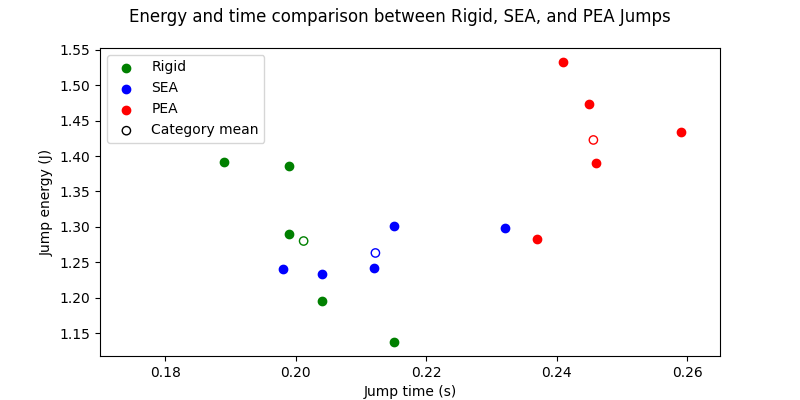

In [98]:
plt.ion()
plt.figure(figsize=(8,4))
%matplotlib widget
size=10

colormap = {
    'Rigid': 'green',
    'SEA': 'blue',
    'PEA': 'red',
}


for label in energy_time_data:
    plt.scatter(energy_time_data[label][:,0], energy_time_data[label][:,1], label=label, color=colormap[label])

    avg_time = np.mean(energy_time_data[label][:,0])
    avg_energy = np.mean(energy_time_data[label][:,1])
    avg_power = avg_energy/avg_time
    print(f"{label}: avg_time={avg_time:.3f}, avg_energy={avg_energy:.2f}, avg_power={avg_power:.2f}")

    # plt.text(avg_time, avg_energy+0.01, f'{avg_time*1000:.0f}ms, {avg_energy:.2f}J', color=colormap[label])

    plt.scatter(avg_time, avg_energy, facecolors='none', edgecolors=colormap[label]) 

    # plt.scatter(avg_time, avg_energy, label=f"avg {label}") 
    # plt.scatter(energy_time_data['PEA'][:,0], energy_time_data['PEA'][:,1], s=size, label='PEA')
    # plt.scatter(energy_time_data['Rigid'][:,0], energy_time_data['Rigid'][:,1], s=size)
    # plt.scatter(energy_time_data['SEA'][:,0], energy_time_data['SEA'][:,1], s=size)
plt.xlim(0.17, 0.265)
# plt.ylim(0.18, 0.27)
plt.scatter(0, 1.4, label='Category mean', facecolors='none', edgecolors='black') 
# plt.axhline(color='k')
# plt.axvline(color='k')
plt.suptitle('Energy and time comparison between Rigid, SEA, and PEA Jumps')
plt.xlabel('Jump time (s)') #eventually should be time spent
plt.ylabel('Jump energy (J)')
plt.legend(loc='upper left')